_Lambda School Data Science_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Permutation Importances, Partial Dependence Plots

## Overview

### Objectives
- Get and interpret permutation importances
- Visualize and interpret partial dependence plots

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding): `conda install -c conda-forge category_encoders` / `pip install category_encoders`

### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas didn't work. The bug seems to be fixed now, but if you have problems, [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

4. With PDPBox version <= 0.20, using the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works. [This issue](https://github.com/SauceCat/PDPbox/issues/40) will be fixed in the next release of PDPbox.

**[(Data science is often about putting square pegs in round holes!)](https://www.youtube.com/watch?v=ry55--J4_VQ)**

### Three types of model explanations:

**1. Global model explanation: all features in relation to each other**
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

**2. Global model explanation: individual feature(s) in relation to target**
- Partial Dependence plots

**3. Individual prediction explanation**
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

## Setup

### Install dependencies

In [1]:
# For Google Colab.
# !pip install eli5 pdpbox category_encoders

### Import libraries

In [134]:
import category_encoders as ce
import eli5
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdpbox
import shap
import urllib.request
import zipfile

%matplotlib inline

ModuleNotFoundError: No module named 'shap'

In [91]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Define utility functions

In [46]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [68]:
def custom_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return -rmse(y_true, y_pred)

### Load data

Data source: [National Center for Education Statistics](https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx)

In [4]:
data_urls = ['https://nces.ed.gov/ipeds/datacenter/data/HD2017.zip',
             'https://nces.ed.gov/ipeds/datacenter/data/IC2017.zip',
             'https://nces.ed.gov/ipeds/datacenter/data/IC2017_AY.zip',
            ]

data_files = ['HD2017.zip',
              'IC2017.zip', 
              'IC2017_AY.zip', 
             ]

In [5]:
for url, file in zip(data_urls, data_files):
    urllib.request.urlretrieve(url, file)

In [6]:
for file in data_files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('.\Data')

In [7]:
institutions = pd.read_csv('Data\hd2017.csv', encoding='ISO-8859-1')

In [8]:
institutions.columns

Index(['UNITID', 'INSTNM', 'IALIAS', 'ADDR', 'CITY', 'STABBR', 'ZIP', 'FIPS',
       'OBEREG', 'CHFNM', 'CHFTITLE', 'GENTELE', 'EIN', 'DUNS', 'OPEID',
       'OPEFLAG', 'WEBADDR', 'ADMINURL', 'FAIDURL', 'APPLURL', 'NPRICURL',
       'VETURL', 'ATHURL', 'DISAURL', 'SECTOR', 'ICLEVEL', 'CONTROL',
       'HLOFFER', 'UGOFFER', 'GROFFER', 'HDEGOFR1', 'DEGGRANT', 'HBCU',
       'HOSPITAL', 'MEDICAL', 'TRIBAL', 'LOCALE', 'OPENPUBL', 'ACT', 'NEWID',
       'DEATHYR', 'CLOSEDAT', 'CYACTIVE', 'POSTSEC', 'PSEFLAG', 'PSET4FLG',
       'RPTMTH', 'INSTCAT', 'C15BASIC', 'C15IPUG', 'C15IPGRD', 'C15UGPRF',
       'C15ENPRF', 'C15SZSET', 'CCBASIC', 'CARNEGIE', 'LANDGRNT', 'INSTSIZE',
       'F1SYSTYP', 'F1SYSNAM', 'F1SYSCOD', 'CBSA', 'CBSATYPE', 'CSA', 'NECTA',
       'COUNTYCD', 'COUNTYNM', 'CNGDSTCD', 'LONGITUD', 'LATITUDE', 'DFRCGID',
       'DFRCUSCG'],
      dtype='object')

In [9]:
institution_details = pd.read_csv('Data\ic2017.csv', encoding='ISO-8859-1')

In [10]:
institution_details.columns.to_list()

['UNITID',
 'PEO1ISTR',
 'PEO2ISTR',
 'PEO3ISTR',
 'PEO4ISTR',
 'PEO5ISTR',
 'PEO6ISTR',
 'CNTLAFFI',
 'PUBPRIME',
 'PUBSECON',
 'RELAFFIL',
 'LEVEL1',
 'LEVEL2',
 'LEVEL3',
 'LEVEL4',
 'LEVEL5',
 'LEVEL6',
 'LEVEL7',
 'LEVEL8',
 'LEVEL12',
 'LEVEL17',
 'LEVEL18',
 'LEVEL19',
 'CALSYS',
 'FT_UG',
 'FT_FTUG',
 'FTGDNIDP',
 'PT_UG',
 'PT_FTUG',
 'PTGDNIDP',
 'DOCPP',
 'DOCPPSP',
 'OPENADMP',
 'VET1',
 'VET2',
 'VET3',
 'VET4',
 'VET5',
 'VET9',
 'CREDITS1',
 'CREDITS2',
 'CREDITS3',
 'CREDITS4',
 'SLO5',
 'SLO51',
 'SLO52',
 'SLO53',
 'SLO6',
 'SLO7',
 'SLO8',
 'SLO81',
 'SLO82',
 'SLO83',
 'SLO9',
 'YRSCOLL',
 'STUSRV1',
 'STUSRV2',
 'STUSRV3',
 'STUSRV4',
 'STUSRV8',
 'STUSRV9',
 'LIBRES1',
 'LIBRES2',
 'LIBRES3',
 'LIBRES4',
 'LIBRES5',
 'LIBRES6',
 'LIBRES9',
 'TUITPL',
 'TUITPL1',
 'TUITPL2',
 'TUITPL3',
 'TUITPL4',
 'DSTNUGC',
 'DSTNUGP',
 'DSTNUGN',
 'DSTNGC',
 'DSTNGP',
 'DSTNGN',
 'DISTCRS',
 'DISTPGS',
 'DSTNCED1',
 'DSTNCED2',
 'DSTNCED3',
 'DISTNCED',
 'DISAB',
 'XDISABPC',
 

In [11]:
detail_features = ['UNITID', 
                   'LEVEL5', 
                   'LIBRES1',
                   'LIBRES2',
                   'LIBRES3',
                   'LIBRES4',
                   'LIBRES5',
                   'LIBRES6',
                   'LIBRES9',
                  ]

In [12]:
tuition = pd.read_csv('Data\ic2017_ay.csv', encoding='ISO-8859-1')

In [13]:
target = 'TUITION3'

In [14]:
data = institutions.merge(institution_details[detail_features])

In [15]:
data.columns

Index(['UNITID', 'INSTNM', 'IALIAS', 'ADDR', 'CITY', 'STABBR', 'ZIP', 'FIPS',
       'OBEREG', 'CHFNM', 'CHFTITLE', 'GENTELE', 'EIN', 'DUNS', 'OPEID',
       'OPEFLAG', 'WEBADDR', 'ADMINURL', 'FAIDURL', 'APPLURL', 'NPRICURL',
       'VETURL', 'ATHURL', 'DISAURL', 'SECTOR', 'ICLEVEL', 'CONTROL',
       'HLOFFER', 'UGOFFER', 'GROFFER', 'HDEGOFR1', 'DEGGRANT', 'HBCU',
       'HOSPITAL', 'MEDICAL', 'TRIBAL', 'LOCALE', 'OPENPUBL', 'ACT', 'NEWID',
       'DEATHYR', 'CLOSEDAT', 'CYACTIVE', 'POSTSEC', 'PSEFLAG', 'PSET4FLG',
       'RPTMTH', 'INSTCAT', 'C15BASIC', 'C15IPUG', 'C15IPGRD', 'C15UGPRF',
       'C15ENPRF', 'C15SZSET', 'CCBASIC', 'CARNEGIE', 'LANDGRNT', 'INSTSIZE',
       'F1SYSTYP', 'F1SYSNAM', 'F1SYSCOD', 'CBSA', 'CBSATYPE', 'CSA', 'NECTA',
       'COUNTYCD', 'COUNTYNM', 'CNGDSTCD', 'LONGITUD', 'LATITUDE', 'DFRCGID',
       'DFRCUSCG', 'LEVEL5', 'LIBRES1', 'LIBRES2', 'LIBRES3', 'LIBRES4',
       'LIBRES5', 'LIBRES6', 'LIBRES9'],
      dtype='object')

In [16]:
data = data[data['LEVEL5'] == 1]

In [17]:
data = data.merge(tuition[['UNITID', target]])

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UNITID,2602.0,2.361966e+05,1.153576e+05,100654.000000,1.577592e+05,1.996250e+05,2.382912e+05,4.912880e+05
FIPS,2602.0,3.012836e+01,1.663271e+01,1.000000,1.700000e+01,3.100000e+01,4.200000e+01,7.800000e+01
OBEREG,2602.0,4.451191e+00,2.216320e+00,0.000000,3.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00
EIN,2602.0,4.817259e+08,2.665898e+08,-1.000000,2.514769e+08,4.646999e+08,6.603773e+08,9.960004e+08
OPEFLAG,2602.0,1.159877e+00,8.833309e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
SECTOR,2602.0,1.882398e+00,6.660937e-01,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
ICLEVEL,2602.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CONTROL,2602.0,1.882398e+00,6.660937e-01,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
HLOFFER,2602.0,7.192929e+00,1.640645e+00,5.000000,5.000000e+00,7.000000e+00,9.000000e+00,9.000000e+00
UGOFFER,2602.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
data.nunique().sort_values(ascending=False).head(25)

UNITID      2602
LATITUDE    2590
LONGITUD    2590
OPEID       2577
INSTNM      2575
ADDR        2562
GENTELE     2549
ZIP         2482
WEBADDR     2442
CHFNM       2412
DISAURL     2243
DUNS        2193
NPRICURL    2165
ADMINURL    2141
FAIDURL     2128
EIN         2080
APPLURL     1944
TUITION3    1874
VETURL      1494
CITY        1269
IALIAS       995
COUNTYCD     953
ATHURL       870
COUNTYNM     728
CBSA         577
dtype: int64

In [20]:
data.loc[data['TUITION3']=='.'] = 0

In [21]:
data['TUITION3'] = data['TUITION3'].astype(int)

In [22]:
data = data[data['UNITID'] != 0]

In [23]:
identifying_features = ['UNITID', 
                        'INSTNM', 
                        'IALIAS', 
                        'ADDR', 
                        'ZIP', 
                        'CHFNM', 
                        'GENTELE', 
                        'EIN', 
                        'DUNS',
                        'OPEID',
                        'WEBADDR', 
                        'DISAURL', 
                        'NPRICURL', 
                        'ADMINURL', 
                        'FAIDURL', 
                        'APPLURL', 
                        'VETURL', 
                        'ATHURL',]

In [24]:
data = data.drop(columns=identifying_features)

In [35]:
string_features = ['CITY', 'STABBR', 'CHFTITLE', 'ACT', 'CLOSEDAT', 'F1SYSNAM', 'COUNTYNM']

In [36]:
data = data.drop(columns=string_features)

## Split into training, validation, and test datasets

In [37]:
trainval, test = train_test_split(data)

In [38]:
train, val = train_test_split(trainval)

In [39]:
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)

y_train = train[target]
y_val = val[target]
y_test = test[target]

## Establish baseline for regression

In [48]:
y_train_pred_bl = np.full_like(y_train, y_train.mean())
y_val_pred_bl = np.full_like(y_val, y_train.mean())

In [49]:
score_bl = rmse(y_val, y_val_pred_bl)
print("Validation RMSE: {:.3f}" .format(score_bl))

Validation RMSE: 12131.271


In [40]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [41]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [42]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's l1: 9791.87	valid_0's l2: 1.3785e+08
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 9466.56	valid_0's l2: 1.29163e+08
[3]	valid_0's l1: 9164.24	valid_0's l2: 1.21472e+08
[4]	valid_0's l1: 8885.44	valid_0's l2: 1.14589e+08
[5]	valid_0's l1: 8601.38	valid_0's l2: 1.0792e+08
[6]	valid_0's l1: 8332.66	valid_0's l2: 1.01648e+08
[7]	valid_0's l1: 8084.85	valid_0's l2: 9.61494e+07
[8]	valid_0's l1: 7882.97	valid_0's l2: 9.20409e+07
[9]	valid_0's l1: 7654.35	valid_0's l2: 8.72591e+07
[10]	valid_0's l1: 7443.45	valid_0's l2: 8.30676e+07
[11]	valid_0's l1: 7234.61	valid_0's l2: 7.91051e+07
[12]	valid_0's l1: 7046.06	valid_0's l2: 7.56793e+07
[13]	valid_0's l1: 6882.06	valid_0's l2: 7.28519e+07
[14]	valid_0's l1: 6712.23	valid_0's l2: 6.99165e+07
[15]	valid_0's l1: 6541.26	valid_0's l2: 6.70491e+07
[16]	valid_0's l1: 6407.39	valid_0's l2: 6.47346e+07
[17]	valid_0's l1: 6283.53	valid_0's l2: 6.26835e+07
[18]	valid_0's l1: 6165.58	valid_0's l2: 6.07818e

In [47]:
y_val_pred = gbm.predict(X_val)
score = rmse(y_val, y_val_pred)
print("Validation RMSE: {:.3f}" .format(score))

Validation RMSE: 7602.754


## Plot feature importances

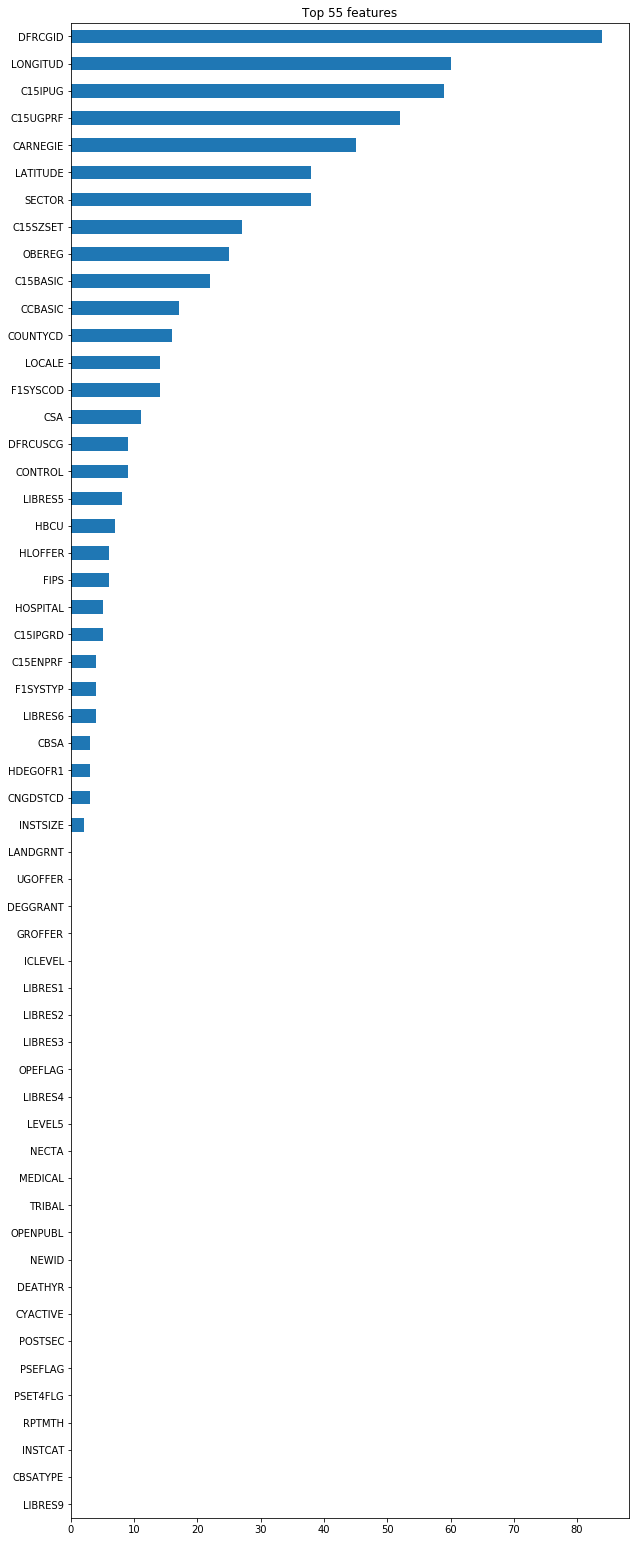

In [53]:
importances = pd.Series(gbm.feature_importance(), X_train.columns)

n = len(X_train.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

## Evaluate permutation importances

In [92]:
model = RandomForestRegressor(n_estimators=10, random_state=0).fit(X_train, y_train)

In [93]:
y_val_pred = model.predict(X_val)
score = rmse(y_val, y_val_pred)
print("Validation RMSE: {:.3f}" .format(score))

Validation RMSE: 6543.965


In [94]:
permuter = eli5.sklearn.PermutationImportance(model, 
                                              scoring='neg_mean_squared_error', 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
77285744.8611 ± 15167617.6482,C15UGPRF
23784308.4734 ± 2369885.7041,DFRCGID
13602598.6215 ± 3462435.8163,SECTOR
8099096.2216 ± 4453830.4738,CARNEGIE
8000793.6918 ± 3926804.0613,OBEREG
7606580.4422 ± 2963254.1181,LONGITUD
4610054.5031 ± 1717781.3362,CONTROL
3475134.8386 ± 935380.9690,C15IPUG
3360107.3836 ± 2307460.2856,C15BASIC
1664689.5981 ± 1064596.6685,CNGDSTCD


In [95]:
permuter = eli5.sklearn.PermutationImportance(model, 
                                              scoring=custom_scorer, 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
4410.1917 ± 680.2203,C15UGPRF
1617.0728 ± 144.9005,DFRCGID
966.8844 ± 229.9415,SECTOR
590.3644 ± 309.3153,CARNEGIE
583.8140 ± 275.9567,OBEREG
556.6901 ± 207.4130,LONGITUD
342.9554 ± 124.2560,CONTROL
260.2564 ± 68.8136,C15IPUG
251.3546 ± 169.9125,C15BASIC
125.8603 ± 79.9651,CNGDSTCD


## Generate partial dependence plots

### Single-feature PDPs

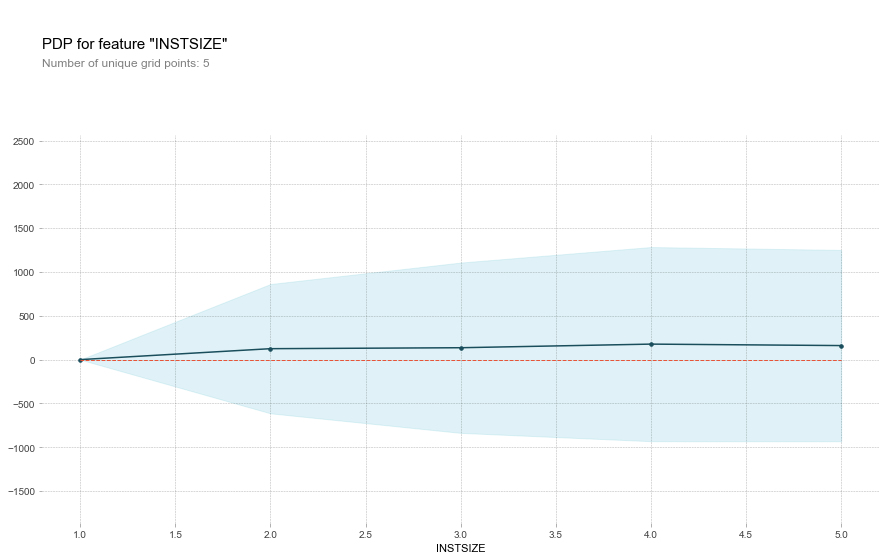

In [101]:
feature = 'INSTSIZE'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

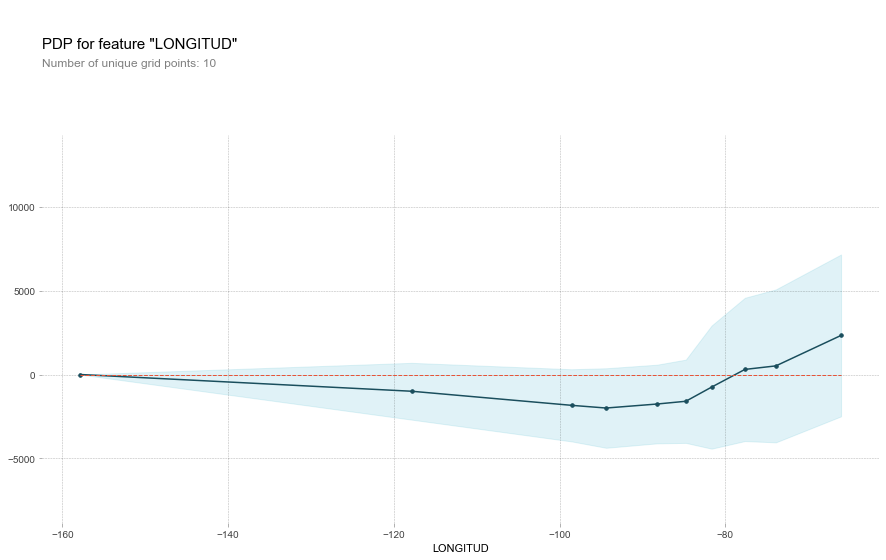

In [100]:
feature = 'LONGITUD'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

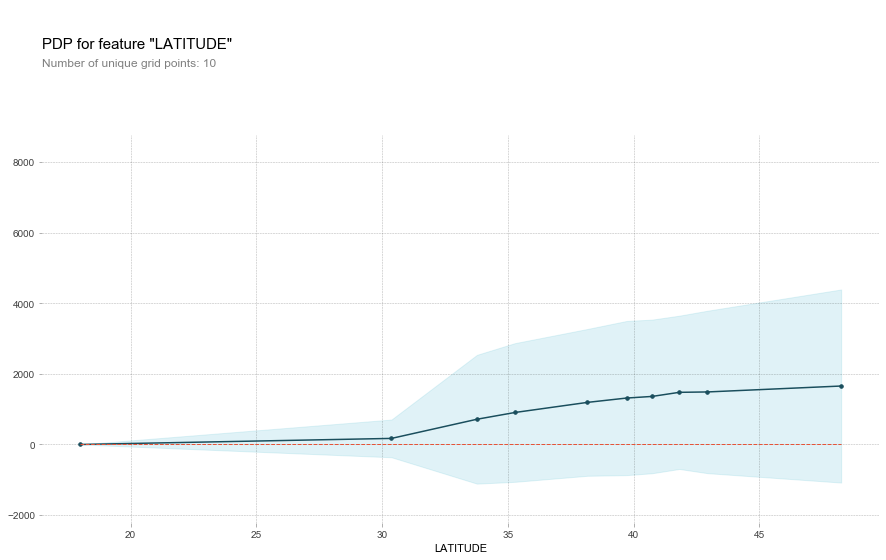

In [102]:
feature = 'LATITUDE'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

### Two-feature PDP

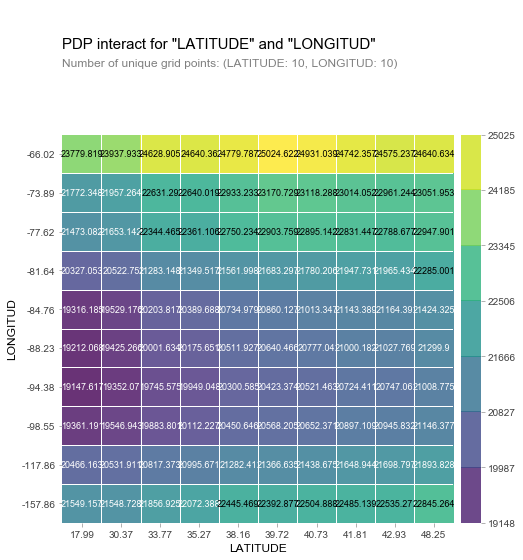

In [103]:
features = ['LATITUDE', 'LONGITUD']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## Generate Shapely value plot

In [129]:
sample = y_val.sample()
sample

2139    10832
Name: TUITION3, dtype: int32

In [130]:
y_val[sample.index[0]]

10832

In [132]:
data_for_prediction= X_val[X_val.index == sample.index[0]]
data_for_prediction

,FIPS,OBEREG,OPEFLAG,SECTOR,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,HDEGOFR1,...,DFRCGID,DFRCUSCG,LEVEL5,LIBRES1,LIBRES2,LIBRES3,LIBRES4,LIBRES5,LIBRES6,LIBRES9
2139,18,3,1,2,1,2,7,1,1,20,...,157,2,1,0,0,1,0,0,1,0


In [133]:
model.predict(data_for_prediction)

array([12473.8])